<a href="https://colab.research.google.com/github/simon-mellergaard/GAI-with-LLMs/blob/main/Project%20codes/question1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

Follow the classification example in Chapter 6 in Hands-On Generative AI with Transformers and Diffusion Models and extend it in the following ways:
1. Perform an error analysis based on the fine-tuned DestilBert model on the AG News dataset.
2. Fine-tune a ModernBert model (answerdotai/ModernBERT-base) in a similar fashion as DestilBert was fine-tuned in the chapter.
3. Compare the test set performance of the two fine-tuned models.
4. Perform an error analysis on the AG News based on the fine-tuned ModernBert and compare it to DestilBert.

## Setup

Loading all the needed functions, libraries and logging in to the services (HF and wandb)

In [1]:
# Installing necessary packages
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.8 MB/s eta 0:00:00


In [4]:
# Libraries
import evaluate
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
#import wandb


from datasets import load_dataset
from google.colab import userdata
from huggingface_hub import login as login_hf
from sklearn.metrics import ConfusionMatrixDisplay
from torch.nn.functional import cross_entropy
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, Trainer, TrainingArguments
from wandb import login as login_wandb

In [3]:
# Logging in to Huggingface and wandb
os.environ['HF_TOKEN'] = userdata.get('HF')
os.environ['WANDB_TOKEN'] = userdata.get('wandb')
login_hf(os.environ['HF_TOKEN'])
login_wandb(key = os.environ['WANDB_TOKEN'])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: simonmellergaard (simonmellergaard-aarhus-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## 1 Error based analysis

> *Perform an error analysis based on the fine-tuned DestilBert model on the AG News dataset.*

First, the data is loaded from HF.

In [33]:
# Loading the raw dataset from HuggingFace and making a training set.
raw_datasets = load_dataset("ag_news") # 120.000 train rows and 7.600 test rows.
raw_train_dataset = raw_datasets["train"]

Here, the DistilBert model is used to tokenize the data. The data is being tokenized based on this.

In [34]:
checkpoint = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(batch):
    return tokenizer(
        batch["text"], truncation=True, padding=True, return_tensors="pt"
    )

tokenize_function(raw_train_dataset[:2])
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

The evaluation metrics are imported to eavalueate the datasets in terms of accuracy and F1-score.

In [41]:
accuracy = evaluate.load("accuracy")
f1_score = evaluate.load("f1")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute accuracy and F1 Score
    acc_result = accuracy.compute(references=labels, predictions=preds)
    acc = acc_result["accuracy"]

    f1_result = f1_score.compute(
        references=labels, predictions=preds, average="weighted"
    )
    f1 = f1_result["f1"]

    return {"accuracy": acc, "f1": f1}

The below code is specifying the model, and connecting it to the GPU.

In [16]:
# defining a get_device function that gets the device of the system (gpu/cpu).
# This function is from the genaibook repository.
def get_device(cuda_ordinal=None):
    if torch.cuda.is_available():
        return torch.device("cuda", cuda_ordinal)
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = get_device()
num_labels = 4
model = (AutoModelForSequenceClassification
         .from_pretrained(checkpoint, num_labels=num_labels)
         .to(device))

Defining the model

In [ ]:
batch_size = 32  # COULD BE CHANGED
training_args = TrainingArguments(
    "classifier-distilbert-agnews",
    push_to_hub=True,
    num_train_epochs=2,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    #report_to="none"
)

Specifying the trainer

In [ ]:
# Shuffle the dataset and pick 10,000 examples for training
shuffled_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_split = shuffled_dataset.select(range(10000))

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=small_split,
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
)

/tmp/ipython-input-946655670.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training the actual model.

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.276913,0.908684,0.908390
2,0.312800,0.261054,0.916447,0.916476


TrainOutput(global_step=626, training_loss=0.2892718939735486, metrics={'train_runtime': 699.6221, 'train_samples_per_second': 28.587, 'train_steps_per_second': 0.895, 'total_flos': 1875180164398464.0, 'train_loss': 0.2892718939735486, 'epoch': 2.0})

The model has now been trained, and it has a training accuracy of 91%, and an equally high F1 score. The validatino loss is 0.26. This is quite good, considering there are 4 classes to predict from.

In [ ]:
trainer.push_to_hub()

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...assifier-chapter4/model.safetensors:   2%|2         | 6.16MB /  268MB            

  ...vents.1757510360.009a0d3d389f.803.0:   1%|          |  61.0B / 6.36kB            

  ...assifier-chapter4/training_args.bin:   1%|          |  55.0B / 5.78kB            

CommitInfo(commit_url='https://huggingface.co/simon-mellergaard/classifier-chapter4/commit/499d80a576f88637cd9d18026f0e5f08b6888e5a', commit_message='End of training', commit_description='', oid='499d80a576f88637cd9d18026f0e5f08b6888e5a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/simon-mellergaard/classifier-chapter4', endpoint='https://huggingface.co', repo_type='model', repo_id='simon-mellergaard/classifier-chapter4'), pr_revision=None, pr_num=None)

In [48]:
# Use a pipeline as a high-level help
pipe = pipeline(
    "text-classification",
    model="simon-mellergaard/classifier-distilbert-agnews",
    device="cuda",
)
pipe(
    """The soccer match between Spain and
Portugal ended in a terrible result for Portugal."""
)

Device set to use cuda


[{'label': 'Sports', 'score': 0.891423225402832}]

In [50]:
# Get the list of label names
label_names = raw_train_dataset.features["label"].names

# Convert predicted labels to ids
label_to_id = {name: i for i, name in enumerate(label_names)}
pred_labels = [label_to_id[pred["label"]] for pred in model_preds]

# Compute confusion matrix
confusion_matrix = evaluate.load("confusion_matrix")
cm = confusion_matrix.compute(
    references=references, predictions=pred_labels, normalize="true"
)["confusion_matrix"]

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
plt.title("Normalized confusion matrix")
plt.show()

KeyError: 'LABEL_2'

Now it should be possible to make an error based analysis of the model. This is done by looking at the predictions that have very high and very low validation loss.

In [51]:
#hide_output
from transformers import pipeline

# Change `transformersbook` to your Hub username
model_id = "simon-mellergaard/classifier-modernbert-agnews"
model = pipeline("text-classification", model=model_id)

config.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


In [52]:
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [53]:
ag_news = load_dataset("ag_news")
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)
ag_news_encoded = ag_news.map(tokenize, batched=True, batch_size=None)
ag_news_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Convert our dataset back to PyTorch tensors
ag_news_encoded.set_format("torch",
                            columns=['text', 'label', 'input_ids', 'attention_mask'])

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [54]:
# Compute loss values
ag_news_encoded["test"] = ag_news_encoded["test"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

TypeError: TextClassificationPipeline.__call__() missing 1 required positional argument: 'inputs'

Getting the test accuracy.

In [55]:
# Get prediction for all samples
model_preds = model.predict(list(tokenized_datasets["test"]["text"]))

# Get the dataset labels
references = tokenized_datasets["test"]["label"]

# Get the list of label names
label_names = raw_train_dataset.features["label"].names

# Print results of the first 3 samples
samples = 3
texts = tokenized_datasets["test"]["text"][:samples]
for pred, ref, text in zip(model_preds[:samples], references[:samples], texts):
    print(f"Predicted {pred['label']}; Actual {label_names[ref]};")
    print(text)

KeyboardInterrupt: 

In [47]:
# Get the testing accuracy
label_to_id = {name: i for i, name in enumerate(label_names)}
pred_labels = [label_to_id[pred["label"]] for pred in model_preds]
pred_labels

{'World': 0, 'Sports': 1, 'Business': 2, 'Sci/Tech': 3}

## 2 Error based analysis on ModernBert

> *Fine-tune a ModernBert model (answerdotai/ModernBERT-base) in a similar fashion as DestilBert was fine-tuned in the chapter.*

The same analysis will be made, but this time with the [ModernBert library](https://huggingface.co/answerdotai/ModernBERT-base).


In [10]:
# Tokenizing with the ModernBERT instead.
checkpoint = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(batch):
    return tokenizer(
        batch["text"], truncation=True, padding=True, return_tensors="pt"
    )

tokenize_function(raw_train_dataset[:2])
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

The compute metrics function is used from the model before.

In [ ]:
# Setting the device to the GPU of the system
device = get_device()
num_labels = 4
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=num_labels
).to(device)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Defining the model as before:

In [ ]:
batch_size = 32  # COULD BE CHANGED
training_args = TrainingArguments(
    "classifier-modernbert-agnews",
    push_to_hub=True,
    num_train_epochs=2,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size
)

In [ ]:
# Shuffle the dataset and pick 10,000 examples for training
shuffled_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_split = shuffled_dataset.select(range(10000))

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=small_split,
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
)

/tmp/ipython-input-929705096.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training a model

In [ ]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.


W0911 12:40:32.204000 1200 torch/_inductor/utils.py:1436] [1/0_1] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.248691,0.912632,0.912548
2,0.268800,0.249549,0.923947,0.923948


TrainOutput(global_step=626, training_loss=0.24026718535743202, metrics={'train_runtime': 1811.4288, 'train_samples_per_second': 11.041, 'train_steps_per_second': 0.346, 'total_flos': 4393473122366208.0, 'train_loss': 0.24026718535743202, 'epoch': 2.0})

Pushing the model to Huggingface

In [ ]:
trainer.push_to_hub()

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...modernbert-agnews/training_args.bin: 100%|##########| 5.84kB / 5.84kB            

  ...modernbert-agnews/model.safetensors:   6%|5         | 33.5MB /  598MB            

  ...ents.1757594422.0adab256b85c.1200.0: 100%|##########| 7.09kB / 7.09kB            

CommitInfo(commit_url='https://huggingface.co/simon-mellergaard/classifier-modernbert-agnews/commit/fca6c0e2bc7850cb042fb8b395fe4d5c58c6f766', commit_message='End of training', commit_description='', oid='fca6c0e2bc7850cb042fb8b395fe4d5c58c6f766', pr_url=None, repo_url=RepoUrl('https://huggingface.co/simon-mellergaard/classifier-modernbert-agnews', endpoint='https://huggingface.co', repo_type='model', repo_id='simon-mellergaard/classifier-modernbert-agnews'), pr_revision=None, pr_num=None)

Showing the confusion matrix

In [ ]:
# Use a pipeline as a high-level help
pipe = pipeline(
    "text-classification",
    model="simon-mellergaard/classifier-distilbert-agnews",
    device="cuda",
)
pipe(
    """The soccer match between Spain and
Portugal ended in a terrible result for Portugal."""
)

config.json:   0%|          | 0.00/753 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda


[{'label': 'Sports', 'score': 0.891423225402832}]

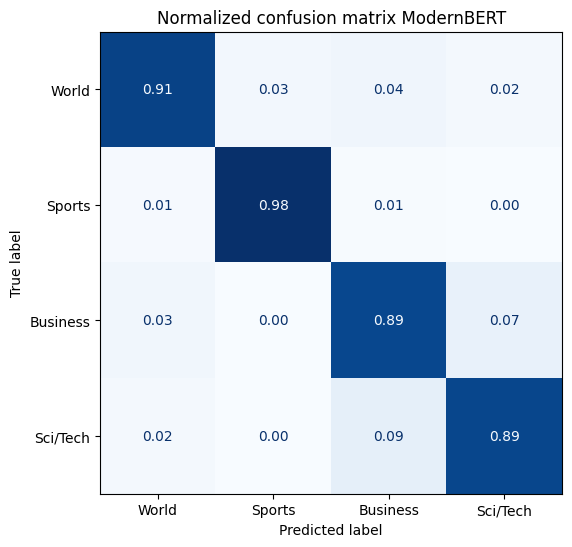

In [ ]:
model_preds = pipe.predict(list(tokenized_datasets["test"]["text"]))
# Get the dataset labels
references = tokenized_datasets["test"]["label"]
# Get the list of label names
label_names = raw_train_dataset.features["label"].names

# Convert predicted labels to ids
label_to_id = {name: i for i, name in enumerate(label_names)}
pred_labels = [label_to_id[pred["label"]] for pred in model_preds]

# Compute confusion matrix
confusion_matrix = evaluate.load("confusion_matrix")
cm = confusion_matrix.compute(
    references=references, predictions=pred_labels, normalize="true"
)["confusion_matrix"]

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
plt.title("Normalized confusion matrix ModernBERT")
plt.show()

The model has now been fine-tuned to the AG-dataset.

## 3 Comparison

> *Compare the test set performance of the two fine-tuned models.*



## 4

> *Perform an error analysis on the AG News based on the fine-tuned ModernBert and compare it to DestilBert.*



In [19]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [20]:
ag_news = load_dataset("ag_news")
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)
ag_news_encoded = ag_news.map(tokenize, batched=True, batch_size=None)
ag_news_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Convert our dataset back to PyTorch tensors
ag_news_encoded.set_format("torch",
                            columns=['text', 'label', 'input_ids', 'attention_mask'])

In [21]:
# Compute loss values
ag_news_encoded["test"] = ag_news_encoded["test"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

NameError: name 'model' is not defined

In [ ]:
def label_int2str(row):
    return ag_news["test"].features["label"].int2str(row)

ag_news_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = ag_news_encoded["test"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

Looking at the most wrongly predicted labels

In [ ]:
pd.set_option('display.max_colwidth', None)
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1197,"World briefs LONDON - A man wielding a machete and a knife attacked two security guards at the building housing the headquarters of the British domestic intelligence service MI5 on Friday, police said.",Business,World,14.847062
1269,"Philippines mourns dead in Russian school siege The Philippines Saturday expressed quot;deepest sympathy quot; to the families of the dead in the Russian school siege on Friday, in which 322 people were killed when Russian troops stormed",Sci/Tech,World,14.121427
2833,"Man arrested for fatally stabbing elderly parents SAITAMA -- A middle-aged man who fatally stabbed his parents has been arrested, police said. Hideo Nakajima, an unemployed man from Soka, Saitama Prefecture, apparently called police shortly before 8 pm, Wednesday.",Sci/Tech,World,10.462741
4300,"City Series-ly wounded With the Yanks out of the World Series, the city #39;s economy loses out on at least \$40 million, according to studies by the controller #39;s office and other city agencies.",Sports,Business,10.258414
912,Bryant Makes First Appearance at Trial (AP) AP - NBA star Kobe Bryant arrived at his sexual assault trial Monday as attorneys in the case who spent the weekend poring over questionnaires prepared to question potential jurors individually.,Sci/Tech,Sports,10.124941
7228,Indonesian diplomats asked to help improve RI #39;s bad image JAKARTA (Antara): President Susilo Yudhoyono asked Indonesian diplomats on Monday to help the government improve Indonesia #39;s bad image.,Business,World,9.669599
5740,"Dow Jones Agrees to Buy MarketWatch in \$519 Million Deal Dow Jones Company, the publisher of The Wall Street Journal, has agreed to buy MarketWatch, the parent company of the financial news Web site CBS MarketWatch, for approximately \$519 million, the companies said today.",World,Business,9.641088
5841,"INSIDE INFO: Man Utd shares drop MAN UNITED #39;S share price has fallen by just over 2.5, less than expected after the resignation of Malcolm Glazer #39;s bankers JP Morgan.",Sports,Business,9.332383
1364,"Hyundai signs deal for China truck plant Hyundai Motor Co. said yesterday that it has signed an agreement with a Chinese company, Jianghuai Automobile Corp., to build a commercial vehicle and engine plant in China #39;s Anhui province.",Sci/Tech,Business,9.212207
4097,"Greenspan: Debt, home prices not dangerous The record level of debt carried by American households and soaring home prices do not appear to represent serious threats to the US economy, Federal Reserve Chairman Alan Greenspan said Tuesday.",Sci/Tech,Business,9.030436


Mostly guessin gbusiness and world, where the actual labels are different.

Looking at the most correctly predicted labels

In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
2901,"80 Killed in U.S. Offensive in Iraq SAMARRA, Iraq - U.S. and Iraqi forces launched a major assault Friday to regain control of the insurgent stronghold of Samarra, and hospital officials said at least 80 people were killed and 100 wounded...",World,World,-0.000000e+00
3528,"Two Car Bombs Kill 10 Iraqis in Baghdad BAGHDAD, Iraq - Two car bombs shook the capital in quick succession Sunday, killing at least 10 Iraqis and wounding 16, police and hospital officials said. One American soldier was hurt...",World,World,-0.000000e+00
1445,"Jakarta Embassy Blast Kills 9, Hurts 173 JAKARTA, Indonesia - Suspected Muslim militants detonated a car bomb Thursday outside the Australian Embassy in Jakarta, killing nine people and wounding 173 in a bloody strike at a key U.S. ally in the war in Iraq...",World,World,-0.000000e+00
2108,"Car Bomb Kills Three in Mosul (AP) AP - A car bomb exploded in the northern Iraq city of Mosul on Monday, killing three people, hospital police said.",World,World,1.192093e-07
4209,"Gas explosion in Chinese coal mine leaves 56 dead, scores missing (Canadian Press) Canadian Press - BEIJING (AP) - A gas explosion in a coal mine in central China killed 56 people and left scores trapped and missing, the government said Thursday.",World,World,1.192093e-07
4378,"Taliban suicide bomber kills girl, wounds 6 others KABUL - A man with six grenades strapped to his body killed himself and a 12-year-old girl on a busy street in Kabul Saturday, police said.",World,World,1.192093e-07
7029,"Six Iraqi national guards, 10 civilians wounded in Mosul attacks MOSUL, Iraq, Dec 9 (AFP) - Six Iraqi national guardsmen and 10 civilians were wounded in two bomb attacks in the northern city of Mosul on Thursday, police said.",World,World,1.192093e-07
1834,"Gunmen Seize Three Britons in Baghdad (Reuters) Reuters - Three British nationals, believed to be\civilians, were snatched by gunmen from a house in central\Baghdad early on Thursday, Iraq's Interior Ministry said.",World,World,1.192093e-07
3533,"Baghdad Car Bombs Kill 11, Including GI BAGHDAD, Iraq - Two car bombs shook the capital in quick succession Sunday, killing at least 11 people, including an American soldier, and wounding 16, U.S. and Iraqi officials said, as Defense Secretary Donald H...",World,World,1.192093e-07
3344,"Two U.S. Soldiers Killed in Iraq Bombings (AP) AP - Two American soldiers were killed and two others were wounded in separate bombings that occurred within hours, the U.S. military said Thursday.",World,World,1.192093e-07


Everything is something about kills, and somebody getting killed. All the predictions are world, and there is basically a loss on 0. Also in general civilians are mentionnend and other things regarding violent actions.